# Analyzing INTERNET speeds in Morocco

In [9]:

from datetime import datetime

import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import requests
import re

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm  # progress bar in Jupyter
from datetime import datetime
from shapely.geometry import Point
from adjustText import adjust_text

from sklearn.ensemble       import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics        import mean_squared_error

from mgwr.gwr    import GWR
from mgwr.sel_bw import Sel_BW

---

## Download data

First, download OOKLA data

In [10]:
def quarter_start(year: int, q: int) -> datetime:
    if not 1 <= q <= 4:
        raise ValueError("Quarter must be within [1, 2, 3, 4]")
    month = [1, 4, 7, 10]
    return datetime(year, month[q - 1], 1)

def quarter_start(year: int, q: int) -> datetime:
    if not 1 <= q <= 4:
        raise ValueError("Quarter must be within [1, 2, 3, 4]")
    month = [1, 4, 7, 10]
    return datetime(year, month[q - 1], 1)

def quarter_end(year: int, q: int) -> datetime:
    if q == 4:
        return datetime(year + 1, 1, 1)
    return quarter_start(year, q + 1)

def get_tile_url(service_type: str, year: int, q: int) -> str | None:
    dt = quarter_start(year, q)
    end_dt = quarter_end(year, q)
    now = datetime.utcnow()

    if now < end_dt:
        print(f"⏩ Skipping {service_type} {year} Q{q} (quarter not yet complete)")
        return None

    base_url = "https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance"
    url = f"{base_url}/type%3D{service_type}/year%3D{dt:%Y}/quarter%3D{q}/{dt:%Y-%m-%d}_performance_{service_type}_tiles.zip"
    return url

def download_file_with_progress(url: str, output_dir: str = "data") -> str:
    os.makedirs(output_dir, exist_ok=True)
    
    local_filename = os.path.join(output_dir, url.split("/")[-1])
    
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kibibyte

    t = tqdm(total=total_size, unit='iB', unit_scale=True, desc=f"Downloading {os.path.basename(local_filename)}")

    with open(local_filename, 'wb') as f:
        for data in response.iter_content(block_size):
            t.update(len(data))
            f.write(data)

    t.close()

    if total_size != 0 and t.n != total_size:
        print("⚠️ WARNING: Download might be incomplete.")
    
    return local_filename

configure ctype,years,and quarters as you need

In [15]:
ctype = ["fixed","mobile"]
years = [2024,2025]
quarters = [1, 2, 3, 4]
for t in ctype :
    for year in years :
        for q in quarters :
            url = get_tile_url(t, year, q)
            download_file_with_progress(url) #uncomment to download

C:\Users\Ahmed\AppData\Local\Temp\ipykernel_62944\3529908371.py:21: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow()


KeyboardInterrupt: 

In [13]:
Morocco = gp.read_file("data/Morocco/morocco.shp")

In [14]:

# List all matching zip files
zip_files = [f for f in os.listdir("data") if f.endswith(".zip") and "tiles" in f]

# Progress bar for loading
for filename in tqdm(zip_files, desc="Loading tiles"):
    path = os.path.join("data", filename)
    try:
        gdf = gp.read_file(path)
        print(f"LOADED : {filename}: {len(gdf)} features")
        name = filename
        gdf = gdf.to_crs(Morocco.crs)
        morocco_tiles = gp.clip(gdf, Morocco)
        output_name = name.replace(".zip", "_morocco.shp")
        output_path = os.path.join("MoroccoData", output_name)
        morocco_tiles.to_file(output_path, driver="ESRI Shapefile")
        print(f"SAVED: {output_path} ({len(morocco_tiles)} features)")
    except Exception as e:
        print(f"❌ Failed to load {filename}: {e}")
    

Loading tiles: 0it [00:00, ?it/s]

extracted from link[ https://github.com/teamookla/ookla-open-data/edit/master/README.md ]

#### Tile Attributes
Each tile contains the following adjoining attributes:

| Field Name        | Type        | Description                                                                                                                             | Notes                                                                                                                                                                              |
|-------------------|-------------|-----------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `avg_d_kbps`      | Integer     | The average download speed of all tests performed in the tile, represented in kilobits per second.                                      |                                                                                                                                                                                    |
| `avg_u_kbps`      | Integer     | The average upload speed of all tests performed in the tile, represented in kilobits per second.                                        |                                                                                                                                                                                    |
| `avg_lat_ms`      | Integer     | The average latency of all tests performed in the tile, represented in milliseconds                                                     |                                                                                                                                                                                    |
| `avg_lat_down_ms` | Integer     | The average latency under load of all tests performed in the tile as measured during the download phase of the test. Represented in ms. | Parquet-only. Added 2023-02-23 beginning in Q4 2022 dataset. This column is sparsely populated-- some rows will have a null value as not all versions of Speedtest can perform this measurement. |
| `avg_lat_up_ms`   | Integer     | The average latency under load of all tests performed in the tile as measured during the upload phase of the test. Represented in ms.   | Parquet-only. Added 2023-02-23 beginning in Q4 2022 dataset. This column is sparsely populated-- some rows will have a null value as not all versions of Speedtest can perform this measurement. |
| `tests`           | Integer     | The number of tests taken in the tile. |
| `devices`         | Integer     | The number of unique devices contributing tests in the tile. |
| `quadkey`         | Text        | The quadkey representing the tile.  |
| `tile_x`			| Numeric	  | X coordinate of the tile's centroid.| Added 2023-07-01 beginning in the Q3 2023 dataset.
| `tile_y`          | Numeric     | Y coordinate of the tile's centroid.| Added 2023-07-01 beginning in the Q3 2023 dataset.


#### Quadkeys

[Quadkeys](https://docs.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system) can act as a unique identifier for the tile. This can be useful for joining data spatially from multiple periods (quarters), creating coarser spatial aggregations without using geospatial functions, spatial indexing, partitioning, and an alternative for storing and deriving the tile geometry.

#### Layers
Two layers are distributed as separate sets of files:

* `performance_mobile_tiles` - Tiles containing tests taken from mobile devices with GPS-quality location and a cellular connection type (e.g. 4G LTE, 5G NR).
* `performance_fixed_tiles` - Tiles containing tests taken from mobile devices with GPS-quality location and a non-cellular connection type (e.g. WiFi, ethernet).

#### Time Period and Update Frequency

Layers are generated based on a quarter year of data (three months) and files will be updated and added on a quarterly basis. A `/year=2020/quarter=1/` period, the first quarter of the year 2020, would include all data generated on or after `2020-01-01` and before `2020-04-01`.

Data is subject to be reaggregated regularly in order to honor Data Subject Access Requests (DSAR) as is applicable in certain jurisdictions under laws including but not limited to General Data Protection Regulation (GDPR), California Consumer Privacy Act (CCPA), and Lei Geral de Proteção de Dados (LGPD). Therefore, data accessed at different times may result in variation in the total number of tests, tiles, and resulting performance metrics.



## LOAD MOROCCO DATA {DEPRECATED SEE NEW ALGO}

In [8]:

DATA_FOLDER = "MoroccoData"

# Grab only shapefiles that end with "_morocco.shp"
Morocco_Data_files = [
    f for f in os.listdir(DATA_FOLDER) 
    if f.endswith("_morocco.shp")
]

# This will accumulate your “wide” data
final_gdf = None

# Regex to capture:
#   2024-01-01_performance_fixed_tiles_morocco.shp
#   group(1) => 2024-01-01
#   group(2) => fixed or mobile
filename_pattern = re.compile(r'(\d{4}-\d{2}-\d{2})_.*?(fixed|mobile).*?_morocco\.shp')

for filename in tqdm(Morocco_Data_files, desc="Loading Morocco tiles"):
    path = os.path.join(DATA_FOLDER, filename)
    try:
        gdf = gp.read_file(path)
        print(f"LOADED : {filename}: {len(gdf)} features")

        # Extract quarter/date and type from filename
        match = filename_pattern.search(filename)
        if not match:
            print(f"❌ Could not parse quarter/type from {filename}")
            continue
        
        quarter_str = match.group(1)  # e.g. "2024-01-01"
        conn_type  = match.group(2)   # e.g. "fixed" or "mobile"
        
        # Build a rename map. We keep 'quadkey' and 'geometry' the same
        rename_map = {}
        for col in gdf.columns:
            if col not in ['quadkey', 'geometry']:
                # Prepend <quarter>_<type>_
                new_col = f"{quarter_str}_{conn_type}_{col}"
                rename_map[col] = new_col
        
        # Rename columns
        gdf_renamed = gdf.rename(columns=rename_map)
        
        # If final_gdf is None, just store this one.
        if final_gdf is None:
            final_gdf = gdf_renamed
        else:
            # We'll do a full outer merge only on 'quadkey'
            # Because tile_x & tile_y do not exist in your shapefiles
            gdf_no_geom = gdf_renamed.drop(columns=['geometry'])
            final_gdf = final_gdf.merge(
                gdf_no_geom,
                on='quadkey',
                how='outer'
            )
    except Exception as e:
        print(f"❌ Failed to load {filename}: {e}")

# At this point, final_gdf is your “wide” GeoDataFrame with columns like:
#   quadkey, geometry, 2024-01-01_fixed_avg_d_kbps, 2024-01-01_fixed_avg_u_kbps, etc.

# Save as a GeoPackage instead of ESRI Shapefile so you don’t lose column names:
final_out = "all_quarters_combined.gpkg"
final_gdf.to_file(final_out, driver="GPKG")
print(f"✅ Saved combined dataset to: {final_out}")


# -----------------------------------------
# Create a second file that has differences 
# between consecutive quarters for each type
import pandas as pd

diff_gdf = final_gdf.copy()

# We’ll parse all columns that match e.g. 2024-01-01_fixed_avg_d_kbps
col_pattern = re.compile(r'(\d{4}-\d{2}-\d{2})_(fixed|mobile)_(.*)')

# Build a structure to group columns by (type, metric), e.g. (fixed, avg_d_kbps).
quarter_type_to_metrics = {}

for col in diff_gdf.columns:
    m = col_pattern.match(col)
    if m:
        q_str = m.group(1)
        t_str = m.group(2)
        metric_name = m.group(3)
        
        # Keep track of columns by quarter
        quarter_type_to_metrics.setdefault((t_str, metric_name), []).append(q_str)

# For each (type, metric), sort quarters & build difference columns
for (conn_type, metric_name), quarter_list in quarter_type_to_metrics.items():
    quarter_list_sorted = sorted(quarter_list)
    for i in range(1, len(quarter_list_sorted)):
        prev_q = quarter_list_sorted[i-1]
        curr_q = quarter_list_sorted[i]
        
        prev_col = f"{prev_q}_{conn_type}_{metric_name}"
        curr_col = f"{curr_q}_{conn_type}_{metric_name}"
        
        # If for some reason we’re missing a column, skip
        if prev_col not in diff_gdf.columns or curr_col not in diff_gdf.columns or metric_name in ['tests', 'devices']:
            continue
        
        diff_col_name = f"D_{curr_q}_M_{prev_q}_{conn_type}_{metric_name}"
        diff_gdf[diff_col_name] = diff_gdf[curr_col] - diff_gdf[prev_col]

# Save differences as well, again in a GeoPackage
diff_out = "all_quarters_differences.gpkg"
diff_gdf.to_file(diff_out, driver="GPKG")
print(f"✅ Saved differences dataset to: {diff_out}")

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'MoroccoData'

In [2]:
# Vérifions le contenu du dossier
data_dir = os.path.join(os.getcwd(), "data")
print("Sous-dossiers de data:", os.listdir(data_dir))


communes_dir = os.path.join(data_dir, "density_population_comune")
print("Fichiers dans density_population_comune:", os.listdir(communes_dir))

# Chemin exact vers le .shp (ajustez selon le nom retourné ci-dessus)
shp_path = os.path.join(communes_dir, "populaion_commune.shp")

# Optionnel : reconstruire le .shx si besoin
os.environ["SHAPE_RESTORE_SHX"] = "YES"

# Chargement GeoPandas
print("Lecture de :", shp_path)
communes = gp.read_file(shp_path)

print("✅ Chargé :", communes.shape, "lignes")
print("CRS :", communes.crs)
print("Colonnes :", communes.columns.tolist())


Sous-dossiers de data: ['2025-01-01_performance_fixed_tiles.zip', 'Morocco', '2024-07-01_performance_mobile_tiles.zip', 'tiles_with_density.csv', 'Morocco-Counties-shapefile', '2024-01-01_performance_mobile_tiles.zip', 'tiles_with_density.gpkg', 'density_population_comune', '2025-01-01_performance_mobile_tiles.zip', '2024-10-01_performance_fixed_tiles.zip', '2024-04-01_performance_fixed_tiles.zip', '2024-01-01_performance_fixed_tiles.zip', '2024-07-01_performance_fixed_tiles.zip', '2024-04-01_performance_mobile_tiles.zip', '2024-10-01_performance_mobile_tiles.zip']
Fichiers dans density_population_comune: ['populaion_commune.dbf', 'populaion_commune.prj', 'populaion_commune.shx', 'populaion_commune.shp', 'populaion_commune.cpg']
Lecture de : /home/anas/Documents/ENSIAS/S4/DATA DRIVEN DECISION MAKING/data/density_population_comune/populaion_commune.shp
✅ Chargé : (1505, 10) lignes
CRS : EPSG:4326
Colonnes : ['Code_Commu', 'Code_Provi', 'CODE_REGIO', 'nom', 'Marocains_', 'Etrangers_', 'P

In [3]:
# @AHMED : why this cell
# 1. Confirmez le répertoire courant
print("Working dir :", os.getcwd())

# 2. Cherchez récursivement les .gpkg
for root, dirs, files in os.walk(os.getcwd()):
    for f in files:
        if f.endswith(".gpkg"):
            print("→ Trouvé :", f, "dans", root)


Working dir : /home/anas/Documents/ENSIAS/S4/DATA DRIVEN DECISION MAKING
→ Trouvé : all_quarters_differences.gpkg dans /home/anas/Documents/ENSIAS/S4/DATA DRIVEN DECISION MAKING
→ Trouvé : all_quarters_combined.gpkg dans /home/anas/Documents/ENSIAS/S4/DATA DRIVEN DECISION MAKING
→ Trouvé : alpha_auto.gpkg dans /home/anas/Documents/ENSIAS/S4/DATA DRIVEN DECISION MAKING/jupyter/lib/python3.12/site-packages/libpysal/cg/tests/data
→ Trouvé : eberly_bounding_circles.gpkg dans /home/anas/Documents/ENSIAS/S4/DATA DRIVEN DECISION MAKING/jupyter/lib/python3.12/site-packages/libpysal/cg/tests/data
→ Trouvé : alpha_fifth.gpkg dans /home/anas/Documents/ENSIAS/S4/DATA DRIVEN DECISION MAKING/jupyter/lib/python3.12/site-packages/libpysal/cg/tests/data
→ Trouvé : alpha_fourth.gpkg dans /home/anas/Documents/ENSIAS/S4/DATA DRIVEN DECISION MAKING/jupyter/lib/python3.12/site-packages/libpysal/cg/tests/data
→ Trouvé : alpha_tenth.gpkg dans /home/anas/Documents/ENSIAS/S4/DATA DRIVEN DECISION MAKING/jupyter/

In [4]:

# 1) Construire le chemin vers le GeoPackage
base_dir   = os.getcwd() 
gpkg_path  = os.path.join(base_dir, "all_quarters_differences.gpkg")

print("Lecture de :", gpkg_path)
tiles = gp.read_file(gpkg_path)

print("✅ Chargé :", tiles.shape, "lignes")
print("Colonnes :", tiles.columns.tolist())


Lecture de : /home/anas/Documents/ENSIAS/S4/DATA DRIVEN DECISION MAKING/all_quarters_differences.gpkg
✅ Chargé : (42997, 76) lignes
Colonnes : ['quadkey', '2024-04-01_fixed_avg_d_kbps', '2024-04-01_fixed_avg_u_kbps', '2024-04-01_fixed_avg_lat_ms', '2024-04-01_fixed_tests', '2024-04-01_fixed_devices', '2024-07-01_fixed_avg_d_kbps', '2024-07-01_fixed_avg_u_kbps', '2024-07-01_fixed_avg_lat_ms', '2024-07-01_fixed_tests', '2024-07-01_fixed_devices', '2024-10-01_fixed_avg_d_kbps', '2024-10-01_fixed_avg_u_kbps', '2024-10-01_fixed_avg_lat_ms', '2024-10-01_fixed_tests', '2024-10-01_fixed_devices', '2024-04-01_mobile_avg_d_kbps', '2024-04-01_mobile_avg_u_kbps', '2024-04-01_mobile_avg_lat_ms', '2024-04-01_mobile_tests', '2024-04-01_mobile_devices', '2024-01-01_fixed_avg_d_kbps', '2024-01-01_fixed_avg_u_kbps', '2024-01-01_fixed_avg_lat_ms', '2024-01-01_fixed_tests', '2024-01-01_fixed_devices', '2024-07-01_mobile_avg_d_kbps', '2024-07-01_mobile_avg_u_kbps', '2024-07-01_mobile_avg_lat_ms', '2024-07-

In [5]:

# 1) Chargez la table des tuiles
tiles = gp.read_file(
    os.path.join("all_quarters_differences.gpkg")
)

# 2) Chargez la couche communes et calculez la densité
communes = gp.read_file(
    os.path.join("data", "density_population_comune", "populaion_commune.shp")
)

# (a) Passez en métrique pour la surface
communes_m = communes.to_crs(epsg=3857)
communes["area_km2"] = communes_m.geometry.area / 1e6

# (b) Calculez densité : population / km²
communes["densite_pop"] = communes["Populati_1"] / communes["area_km2"]

# (c) Remettez en EPSG:4326 pour matcher les tuiles
communes = communes.to_crs(tiles.crs)

# 3) Jointure spatiale « within »  : chaque tuile hérite de la densité de sa commune
tiles_with_pop = gp.sjoin(
    tiles,
    communes[["geometry", "densite_pop"]],
    how="left",
    predicate="within"
)

# 4) (Optionnel) Convertir en DataFrame pandas pour exporter sans géométrie
df_model = pd.DataFrame(tiles_with_pop.drop(columns="geometry"))

# 5) Sauvegarder votre jeu de données enrichi
#  - géopackage si vous voulez garder la géométrie
tiles_with_pop.to_file(
    os.path.join("data", "tiles_with_density.gpkg"),
    driver="GPKG"
)

#  - ou CSV si vous ne voulez que les variables tabulaires
df_model.to_csv(
    os.path.join("data", "tiles_with_density.csv"),
    index=False
)

print("✅ Jeu de données enrichi enregistré :")
print("  • GeoPackage → data/tiles_with_density.gpkg")
print("  • CSV         → data/tiles_with_density.csv")


✅ Jeu de données enrichi enregistré :
  • GeoPackage → data/tiles_with_density.gpkg
  • CSV         → data/tiles_with_density.csv


In [6]:


# 1️⃣ INPUT
# GeoPackage enrichi avec géométrie et densité
in_path = "data/tiles_with_density.gpkg"

# 2️⃣ CHARGEMENT
tiles = gp.read_file(in_path)

# 3️⃣ DÉFINITION DES FEATURES ET DE LA TARGET
features = [
    "2024-10-01_mobile_avg_d_kbps",               # débit mobile dernier trimestre
    "2024-10-01_fixed_avg_d_kbps",                # débit fixe dernier trimestre
    "D_2024-10-01_M_2024-07-01_mobile_avg_d_kbps", # variation mobile Q-1 vs Q-2
    "densite_pop"                                 # densité de population
]
target = "2025-01-01_mobile_avg_d_kbps"           # débit mobile à prédire

# 4️⃣ PRÉPARATION DU JEU D’ENTRAÎNEMENT
df = tiles[features + [target]].dropna()
X, y = df[features], df[target]

# 5️⃣ SPLIT TRAIN / TEST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6️⃣ ENTRAÎNEMENT DU RANDOM FOREST
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# 7️⃣ ÉVALUATION
y_pred = model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"📊 RMSE (test) = {rmse:.2f} kbps")

# 8️⃣ SCORING DE TOUTES LES TUILES
#  - pred_rf   : débit prédit
#  - residu_rf : écart observé − prédit
#  - score_rf  : priorité = densité × (−résidu)
tiles["pred_rf"]   = model.predict(tiles[features].fillna(0))
tiles["residu_rf"] = tiles[target] - tiles["pred_rf"]
tiles["score_rf"]  = - tiles["residu_rf"] * tiles["densite_pop"]

# 9️⃣ EXPORT DES RÉSULTATS
out_path = "data/tiles_score_rf.gpkg"
tiles.to_file(out_path, driver="GPKG")
print(f"✅ Résultats sauvegardés dans {out_path}")


📊 RMSE (test) = 49070.83 kbps
✅ Résultats sauvegardés dans data/tiles_score_rf.gpkg


In [8]:
# 0️⃣ (Jupyter uniquement) Installer mgwr si besoin :
# !pip install mgwr

# 1️⃣ INPUT
in_path = "data/tiles_with_density.gpkg"
tiles   = gp.read_file(in_path)  # CRS EPSG:4326

# 2️⃣ PROJECTION en métrique
tiles_proj = tiles.to_crs(epsg=3857)

# 3️⃣ DÉFINITIONS
target    = "2025-01-01_mobile_avg_d_kbps"
covar_den = "densite_pop"
covar_dl1 = "2024-10-01_mobile_avg_d_kbps"

# 4️⃣ FILTRAGE NaN
cols_needed = [covar_den, covar_dl1, target]
tiles_clean = tiles_proj.dropna(subset=cols_needed)

# 5️⃣ CENTROÏDES + COORDS
centroids = tiles_clean.geometry.centroid
coords    = np.vstack((centroids.x, centroids.y)).T   # shape (n,2)

# 6️⃣ MATRICES X et y
X = tiles_clean[[covar_den, covar_dl1]].values         # (n,2)
y = tiles_clean[[target]].values                       # (n,1)

# 7️⃣ RECHERCHE DE LA BANDE PASSANTE
selector  = Sel_BW(coords, y, X)
bandwidth = selector.search()
print(f"🏎️ Bandwidth retenue : {bandwidth:.2f}")

# 8️⃣ FIT GWR
gwr_model   = GWR(coords, y, X, bandwidth)
gwr_results = gwr_model.fit()

# 9️⃣ PREDICTION EXPLICITE
pred_res = gwr_model.predict(coords, X)
tiles_clean["pred_gwr"]   = pred_res.predictions.flatten()
tiles_clean["residu_gwr"] = tiles_clean[target] - tiles_clean["pred_gwr"]

# 🔟 SCORE DE PRIORITÉ
tiles_clean["score_gwr"] = - tiles_clean["residu_gwr"] * tiles_clean[covar_den]

# 1️⃣1️⃣ REINJECTION dans le GeoDataFrame complet
for col in ["pred_gwr", "residu_gwr", "score_gwr"]:
    tiles_proj.loc[tiles_clean.index, col] = tiles_clean[col]

# 1️⃣2️⃣ REMISE EN CRS ORIGINE
result = tiles_proj.to_crs(tiles.crs)

# 1️⃣3️⃣ EXPORT
out_path = "data/tiles_score_gwr.gpkg"
result.to_file(out_path, driver="GPKG")
print(f"✅ GeoPackage GWR enregistré dans : {out_path}")


🏎️ Bandwidth retenue : 230.00


/home/anas/Documents/ENSIAS/S4/DATA DRIVEN DECISION MAKING/jupyter/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/anas/Documents/ENSIAS/S4/DATA DRIVEN DECISION MAKING/jupyter/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/anas/Documents/ENSIAS/S4/DATA DRIVEN DECISION MAKING/jupyter/lib/python3.12/site-packages/geop

✅ GeoPackage GWR enregistré dans : data/tiles_score_gwr.gpkg


In [27]:
# 1️⃣ Contexte & dépendances
#   * hdbscan pour le clustering, sklearn pour la normalisation
import os
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
import hdbscan

# 2️⃣ Inputs
#   - Toujours “tiles_with_density.gpkg”
#   - On clusterise sur :
#       • 2024-10-01_mobile_avg_d_kbps
#       • D_2024-10-01_M_2024-07-01_mobile_avg_d_kbps
#       • densite_pop
tiles = gpd.read_file("data/tiles_with_density.gpkg")

feat = tiles[[
    "2024-10-01_mobile_avg_d_kbps",
    "D_2024-10-01_M_2024-07-01_mobile_avg_d_kbps",
    "densite_pop"
]].fillna(0)

# 3️⃣ Étapes clés
# 3.1 Standardisation
Xs = StandardScaler().fit_transform(feat)

# 3.2 Clustering HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
labels    = clusterer.fit_predict(Xs)
tiles["cluster"] = labels

# 3.3 Définir les clusters critiques
#    On considère critiques ceux dont la densité est dans le top 25% et débit dans le bottom 25%
summary = tiles.groupby("cluster").agg({
    "densite_pop": "mean",
    "2024-10-01_mobile_avg_d_kbps": "mean"
})
dens_high = summary["densite_pop"].quantile(0.75)
dl_low    = summary["2024-10-01_mobile_avg_d_kbps"].quantile(0.25)
top_clusters = summary[
    (summary["densite_pop"] >= dens_high) &
    (summary["2024-10-01_mobile_avg_d_kbps"] <= dl_low)
].index.tolist()

# 3.4 Score binaire : 1 si cluster critique, 0 sinon
tiles["score_hdb"] = tiles["cluster"].apply(lambda c: 1 if c in top_clusters else 0)

# 4️⃣ Outputs
#   - Dans `tiles` :
#       • cluster    : label HDBSCAN
#       • score_hdb  : indicateur de zone critique
tiles.to_file("data/tiles_score_hdb.gpkg", driver="GPKG")
print("➡️ résultats sauvegardés dans data/tiles_score_hdb.gpkg")


C:\Users\Ahmed\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Ahmed\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


➡️ résultats sauvegardés dans data/tiles_score_hdb.gpkg


## LOAD MOROCCO DATA

In [ ]:
# 0. load provinces
PROVINCES_DATA = "data/density_populatiopn_provinces/morocco_density_province.shp"
provinces = gp.read_file(PROVINCES_DATA)

# 1. collect DataFrames here
df_list = pd.DataFrame()

# 2. our loader returns a small GeoDataFrame with the stats + dims
def Load_Quarter(quarter_path, ttype, quarter_value):
    # read and reproject
    quarters = gp.read_file(os.path.join(DATA_FOLDER, quarter_path))
    if provinces.crs != quarters.crs:
        quarters = quarters.to_crs(provinces.crs)

    # spatial join
    joined = gp.sjoin(quarters, provinces[['geometry','Code_Provi','nom']],
                      how='inner', predicate='intersects')

    # weighted sums
    joined = joined.assign(
        w_d   = joined['avg_d_kbps'] * joined['tests'],
        w_u   = joined['avg_u_kbps'] * joined['tests'],
        w_lat = joined['avg_lat_ms'] * joined['tests'],
    )

    # group + named aggregations
    agg = joined.groupby('index_right').agg(
        sum_tests   = ('tests', 'sum'),
        sum_devices = ('devices', 'sum'),
        sum_w_d     = ('w_d',   'sum'),
        sum_w_u     = ('w_u',   'sum'),
        sum_w_lat   = ('w_lat', 'sum'),
    )

    # compute weighted means
    agg['mean_avg_d_kbps'] = agg['sum_w_d']   / agg['sum_tests']
    agg['mean_avg_u_kbps'] = agg['sum_w_u']   / agg['sum_tests']
    agg['mean_avg_lat_ms'] = agg['sum_w_lat'] / agg['sum_tests']

    # drop intermediates
    agg = agg.drop(columns=['sum_w_d','sum_w_u','sum_w_lat'])

    # merge
    temp = provinces.join(agg, how='left')
    temp[['sum_tests','sum_devices',
          'mean_avg_d_kbps','mean_avg_u_kbps','mean_avg_lat_ms']] = \
        temp[['sum_tests','sum_devices',
              'mean_avg_d_kbps','mean_avg_u_kbps','mean_avg_lat_ms']].fillna(0)

    # select only the columns we need, plus our new dims
    df = temp[['Code_Provi',
               'mean_avg_d_kbps',
               'mean_avg_u_kbps',
               'mean_avg_lat_ms',
               'sum_tests',
               #'sum_devices'
              ]].copy()

    # return a plain pandas DataFrame
    return pd.DataFrame(df)

# 3. loop over your files, build up df_list
DATA_FOLDER = "MoroccoData"
pattern = re.compile(r'(\d{4}-\d{2}-\d{2})_.*?(fixed|mobile).*?_morocco\.shp')

for fname in tqdm(os.listdir(DATA_FOLDER), desc="Loading Morocco tiles"):
    if not fname.endswith("_morocco.shp"):
        continue
    m = pattern.search(fname)
    if not m:
        print(f"❌ can't parse date/type from {fname}")
        continue

    date_str = m.group(1)
    conn_t  = m.group(2)
    try:
        df_quarter = Load_Quarter(fname, conn_t, date_str)
        df_quarter['type']    = conn_t
        df_quarter['quarter'] = date_str
        df_list = pd.concat([df_list, df_quarter], ignore_index=True)
    except Exception as e:
        print(f"❌ failed {fname}: {e}")

# 4. concatenate them all
#result = pd.concat(df_list, ignore_index=True)

# 5. inspect
print(df_list.head())
print(df_list.shape)   # should be (#provinces * #files, 6)


Loading Morocco tiles:   0%|          | 0/10 [00:00<?, ?it/s]

## DENSITE DE POPULATION

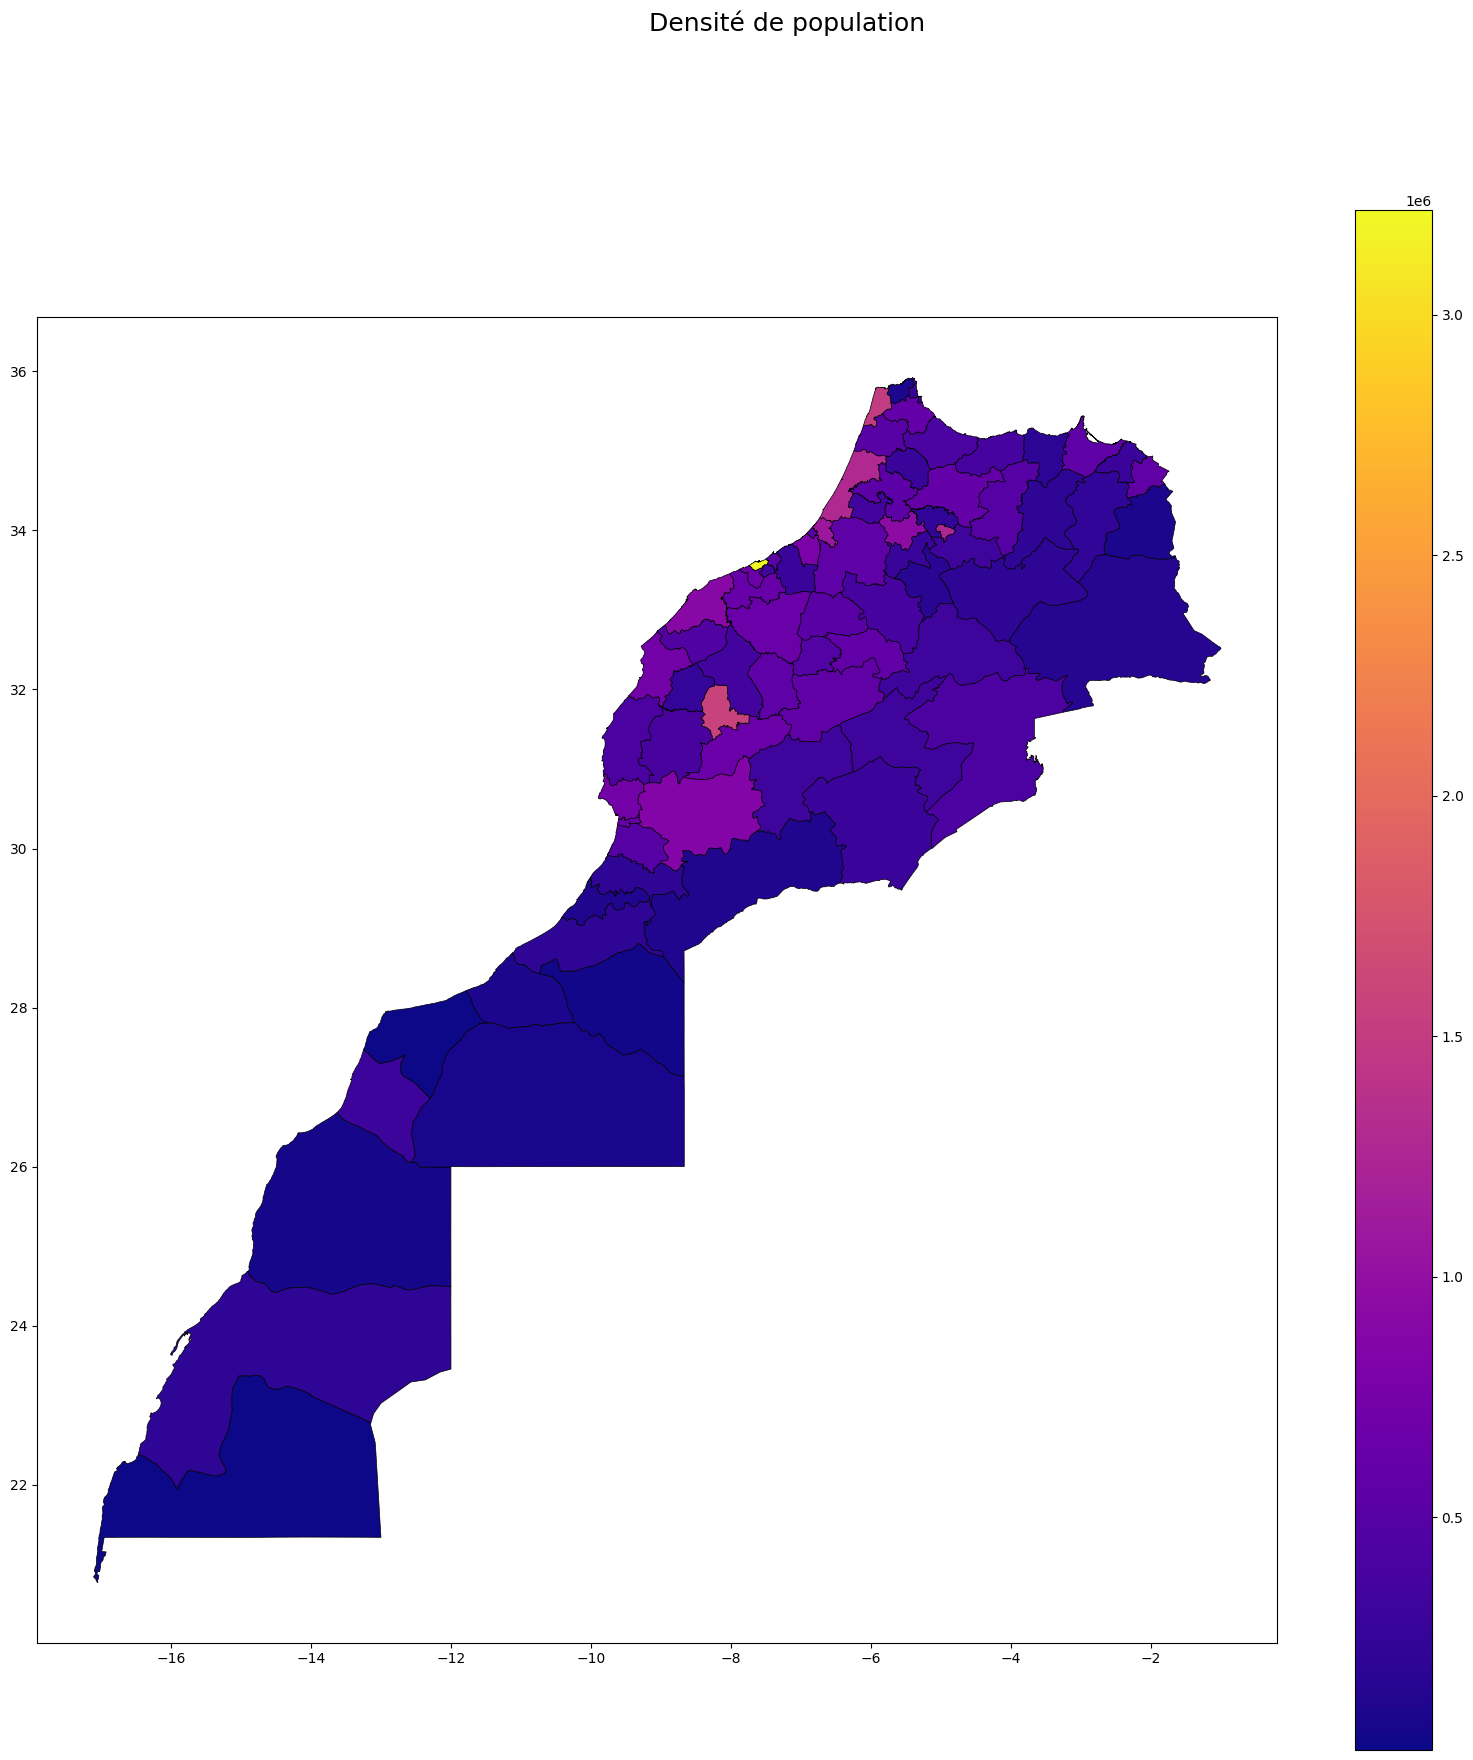

In [83]:

fig, axes = plt.subplots(1, 1, figsize=(20, 20))
provinces.plot(
    ax=axes,
    column='Population',
    cmap=plt.colormaps["plasma"],
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    vmin=provinces['Population'].min(),
    vmax= provinces['Population'].max() 
)
ax.set_title('densite d epopulation', fontsize=14)
ax.set_axis_off()
fig.suptitle("Densité de population", fontsize=18)
#fig.savefig(
#    "provinces_maps.png",   # output filename
#    dpi=300,                # resolution in dots per inch
#    bbox_inches='tight'     # trim extra whitespace
#)


plt.show()

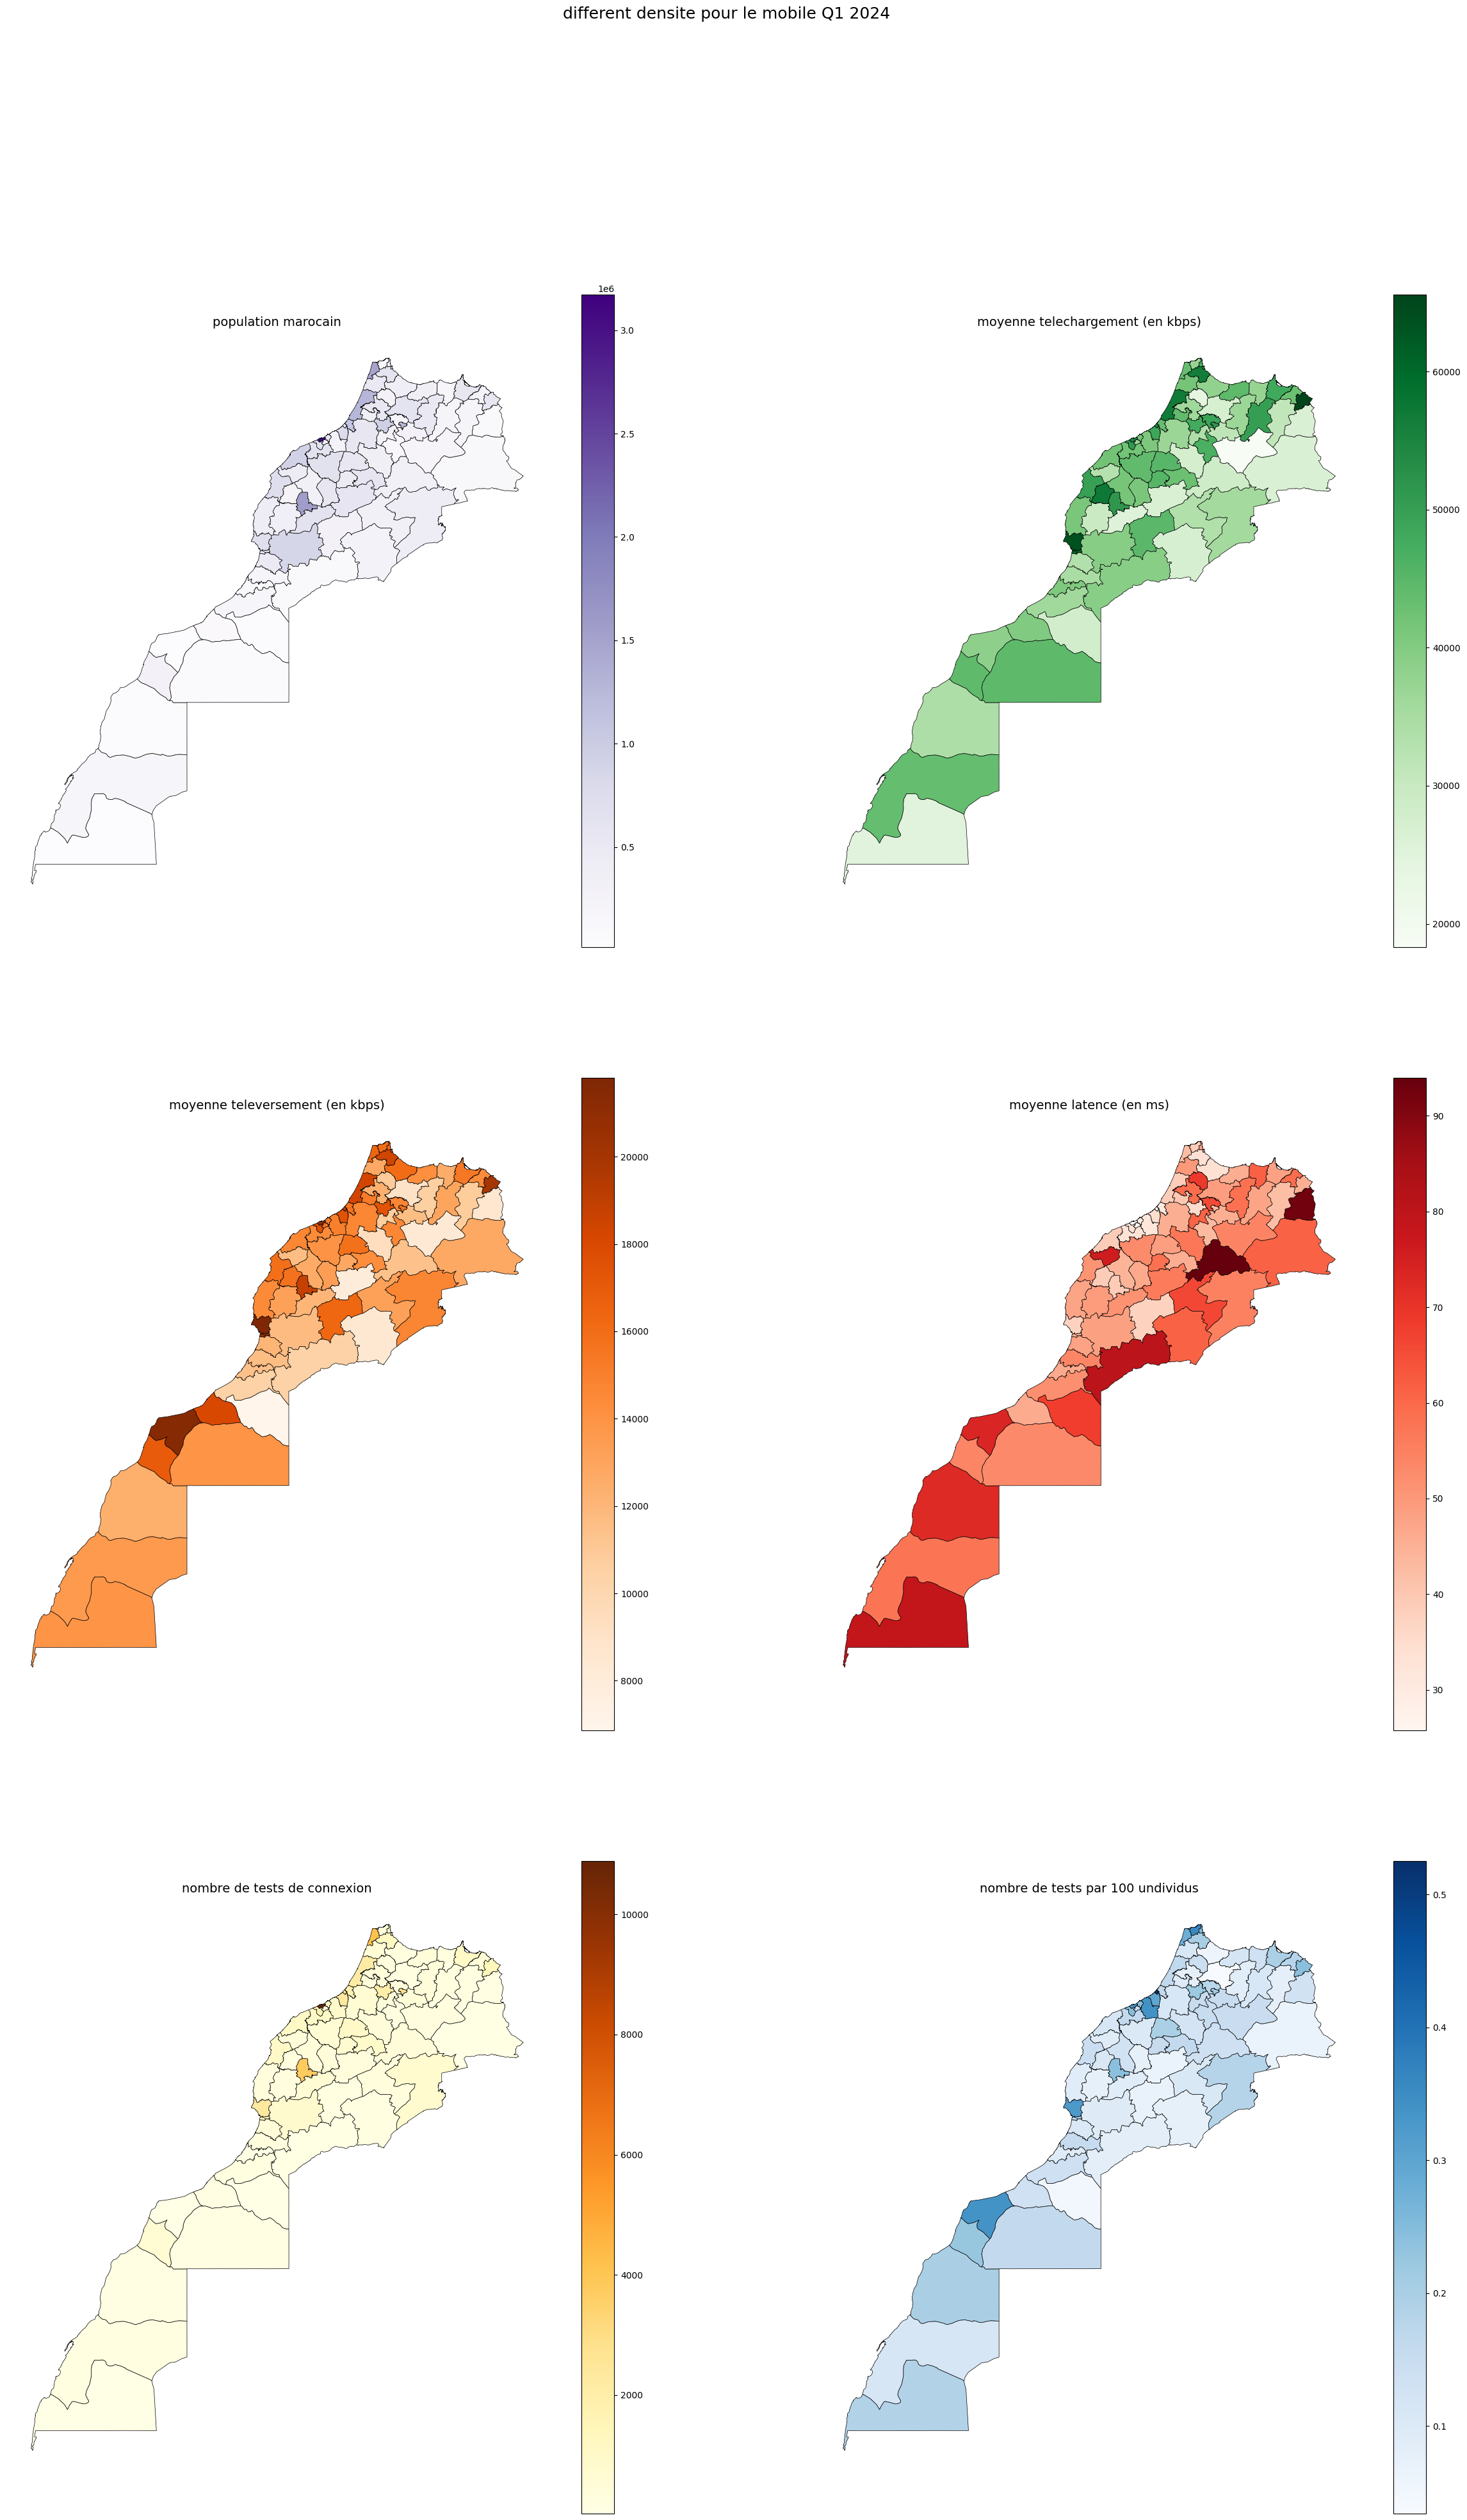

In [87]:


# columns to plot
cols = ['Marocains_', 'mean_avg_d_kbps','mean_avg_u_kbps', 'mean_avg_lat_ms','sum_tests','tests_per_population']
titles = ['population marocain', 'moyenne telechargement (en kbps)','moyenne televersement (en kbps)', 'moyenne latence (en ms)','nombre de tests de connexion','nombre de tests par 100 undividus']

# compute per-column min/max (optional: you could also choose a common vmin/vmax)
vmin = {c: provinces[c].min() for c in cols}
vmax = {c: provinces[c].max() for c in cols}
cmaps= ['Purples','Greens','Oranges','Reds','YlOrBr','Blues']

# create a 1×2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(30, 45))
axes = axes.flatten() 

for ax, col ,title,cmap in zip(axes, cols,titles,cmaps):
    provinces.plot(
        ax=ax,
        column=col,
        cmap=plt.colormaps[cmap],
        legend=True,
        edgecolor='black',
        linewidth=0.5,
        vmin=vmin[col],
        vmax= vmax[col]
    )
    ax.set_title(title, fontsize=14)
    ax.set_axis_off()
fig.suptitle("different densite pour le mobile Q1 2024", fontsize=18)

#fig.savefig(
#    "provinces_maps.png",   # output filename
#    dpi=300,                # resolution in dots per inch
#    bbox_inches='tight'     # trim extra whitespace
#)


plt.show()


In [21]:
output_path = "data/temp/temp.shp"

provinces.to_file(
    filename=output_path,
    driver="ESRI Shapefile"
)

/tmp/ipykernel_385331/670966857.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  provinces.to_file(
/home/anas/Documents/ENSIAS/S4/DATA DRIVEN DECISION MAKING/jupyter/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'sum_devices' to 'sum_device'
  ogr_write(
/home/anas/Documents/ENSIAS/S4/DATA DRIVEN DECISION MAKING/jupyter/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'mean_avg_d_kbps' to 'mean_avg_d'
  ogr_write(
/home/anas/Documents/ENSIAS/S4/DATA DRIVEN DECISION MAKING/jupyter/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'mean_avg_u_kbps' to 'mean_avg_u'
  ogr_write(
/home/anas/Documents/ENSIAS/S4/DATA DRIVEN DECISION MAKING/jupyter/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'mean_avg_lat_ms' to 'mean_avg_l'
  ogr_writ

In [26]:
print(vmax)

{'Marocains_': np.int64(36680178), 'mean_avg_d_kbps': np.float64(229273.90874524714)}


## modeles 
- XGBOOST ML
- RANDOM FOREST ML
- SVM/LOGISTIC REGRESSION ML
- LIGHTGBM

In [2]:
# 0. load provinces
PROVINCES_DATA = "data/density_populatiopn_provinces/morocco_density_province.shp"
provinces = gp.read_file(PROVINCES_DATA)

# 1. collect DataFrames here
df_list = pd.DataFrame()

# 2. our loader returns a small GeoDataFrame with the stats + dims
def Load_Quarter(quarter_path, ttype, quarter_value):
    # read and reproject
    quarters = gp.read_file(os.path.join(DATA_FOLDER, quarter_path))
    if provinces.crs != quarters.crs:
        quarters = quarters.to_crs(provinces.crs)

    # spatial join
    joined = gp.sjoin(quarters, provinces[['geometry','Code_Provi','nom']],
                      how='inner', predicate='intersects')

    # weighted sums
    joined = joined.assign(
        w_d   = joined['avg_d_kbps'] * joined['tests'],
        w_u   = joined['avg_u_kbps'] * joined['tests'],
        w_lat = joined['avg_lat_ms'] * joined['tests'],
    )

    # group + named aggregations
    agg = joined.groupby('index_right').agg(
        sum_tests   = ('tests', 'sum'),
        sum_devices = ('devices', 'sum'),
        sum_w_d     = ('w_d',   'sum'),
        sum_w_u     = ('w_u',   'sum'),
        sum_w_lat   = ('w_lat', 'sum'),
    )

    # compute weighted means
    agg['mean_avg_d_kbps'] = agg['sum_w_d']   / agg['sum_tests']
    agg['mean_avg_u_kbps'] = agg['sum_w_u']   / agg['sum_tests']
    agg['mean_avg_lat_ms'] = agg['sum_w_lat'] / agg['sum_tests']

    # drop intermediates
    agg = agg.drop(columns=['sum_w_d','sum_w_u','sum_w_lat'])

    # merge
    temp = provinces.join(agg, how='left')
    temp[['sum_tests','sum_devices',
          'mean_avg_d_kbps','mean_avg_u_kbps','mean_avg_lat_ms']] = \
        temp[['sum_tests','sum_devices',
              'mean_avg_d_kbps','mean_avg_u_kbps','mean_avg_lat_ms']].fillna(0)

    # select only the columns we need, plus our new dims
    df = temp[['Code_Provi',
               'mean_avg_d_kbps',
               'mean_avg_u_kbps',
               'mean_avg_lat_ms',
               'sum_tests',
               #'sum_devices'
              ]].copy()

    # return a plain pandas DataFrame
    return pd.DataFrame(df)

# 3. loop over your files, build up df_list
DATA_FOLDER = "MoroccoData"
pattern = re.compile(r'(\d{4}-\d{2}-\d{2})_.*?(fixed|mobile).*?_morocco\.shp')

for fname in tqdm(os.listdir(DATA_FOLDER), desc="Loading Morocco tiles"):
    if not fname.endswith("_morocco.shp"):
        continue
    m = pattern.search(fname)
    if not m:
        print(f"❌ can't parse date/type from {fname}")
        continue

    date_str = m.group(1)
    conn_t  = m.group(2)
    try:
        df_quarter = Load_Quarter(fname, conn_t, date_str)
        df_quarter['type']    = conn_t
        df_quarter['quarter'] = date_str
        df_list = pd.concat([df_list, df_quarter], ignore_index=True)
    except Exception as e:
        print(f"❌ failed {fname}: {e}")

# 4. concatenate them all
#result = pd.concat(df_list, ignore_index=True)

# 5. inspect
print(df_list.head())
print(df_list.shape)   # should be (#provinces * #files, 6)


Loading Morocco tiles:   0%|          | 0/50 [00:00<?, ?it/s]

  Code_Provi  mean_avg_d_kbps  mean_avg_u_kbps  mean_avg_lat_ms  sum_tests  \
0    01.051.     34956.899500     29753.127606        39.133445     2398.0   
1    03.271.     39954.658574     37502.911157        37.114153     1936.0   
2    03.531.     29856.931643     24836.143330        48.639471      907.0   
3    04.291.     38057.355116     33019.675855        33.113832     6167.0   
4    01.151.     35178.151907     30117.764986        48.737738     1468.0   

    type     quarter  
0  fixed  2024-04-01  
1  fixed  2024-04-01  
2  fixed  2024-04-01  
3  fixed  2024-04-01  
4  fixed  2024-04-01  
(750, 7)


C:\Users\Ahmed\AppData\Local\Temp\ipykernel_62944\2492638288.py:62: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq        = Queen.from_dataframe(provs_gdf)
C:\Users\Ahmed\AppData\Roaming\Python\Python312\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 12, 44.
  W.__init__(self, neighbors, ids=ids, **kw)


0:	learn: 10253.9951507	test: 12211.4413249	best: 12211.4413249 (0)	total: 30.5ms	remaining: 30.5s
100:	learn: 5108.7795737	test: 8292.7415020	best: 8292.7415020 (100)	total: 3.41s	remaining: 30.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8242.707884
bestIteration = 120

Shrink model to first 121 iterations.

Test RMSE : 8242.71 kbps
Test R²   : 0.527


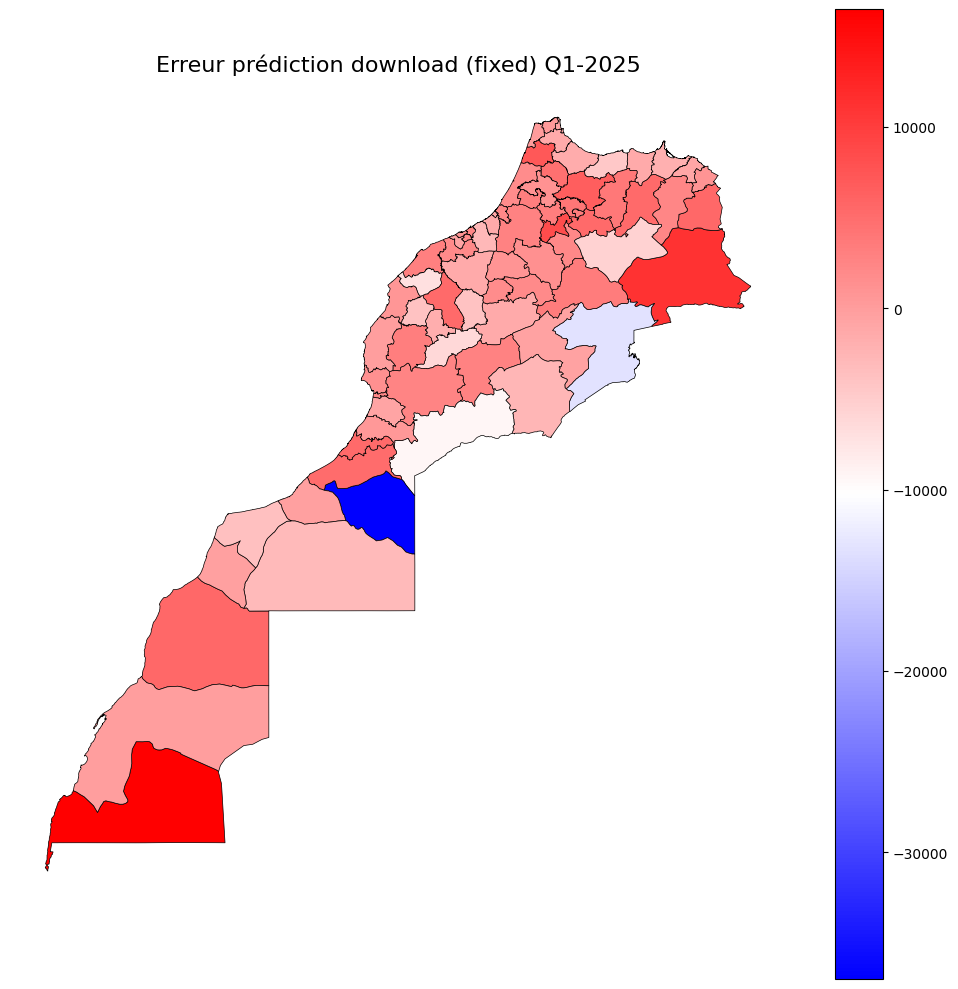

In [43]:
# -*- coding: utf-8 -*-
"""
Prédiction de mean_avg_d_kbps pour Q1-2025 avec CatBoost,
features spatio-temporelles, et carte des écarts.
"""

# 1) Imports
import os, re
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, r2_score
from libpysal.weights import Queen

# 2) Chargement & agrégation
def load_quarters(provinces_shp, data_folder):
    provs = gp.read_file(provinces_shp)
    pat   = re.compile(r'(\d{4}-\d{2}-\d{2})_.*?(fixed|mobile).*?_morocco\.shp')
    rows  = []
    for fn in os.listdir(data_folder):
        m = pat.search(fn)
        if not m: 
            continue
        quarter, typ = m.group(1), m.group(2)
        shp = gp.read_file(os.path.join(data_folder, fn)).to_crs(provs.crs)
        j   = gp.sjoin(shp, provs[['geometry','Code_Provi']], how='inner', predicate='intersects')
        j['w_d'] = j['avg_d_kbps'] * j['tests']
        agg = j.groupby('index_right').agg(
            sum_tests       = ('tests','sum'),
            sum_devices     = ('devices','sum'),
            mean_avg_d_kbps = ('w_d',   lambda x: x.sum()/j.loc[x.index,'tests'].sum())
        )
        tmp = provs.join(agg, how='left').fillna(0)
        df  = tmp[['Code_Provi','sum_tests','sum_devices','mean_avg_d_kbps']].copy()
        df['type']    = typ
        df['quarter'] = quarter
        rows.append(df)
    return pd.concat(rows, ignore_index=True)

provinces_shp = "data/density_populatiopn_provinces/morocco_density_province.shp"
data_folder   = "MoroccoData"
df = load_quarters(provinces_shp, data_folder)

# 3) Feature engineering temporel
quarters = sorted(df['quarter'].unique())
qmap     = {q:i for i,q in enumerate(quarters)}
L        = len(quarters)
df['quarter_num'] = df['quarter'].map(qmap)
df['q_sin']       = np.sin(2*np.pi * df['quarter_num']/L)
df['q_cos']       = np.cos(2*np.pi * df['quarter_num']/L)

df.sort_values(['Code_Provi','type','quarter_num'], inplace=True)
df['lag1_d']  = df.groupby(['Code_Provi','type'])['mean_avg_d_kbps'].shift(1)
df['lag2_d']  = df.groupby(['Code_Provi','type'])['mean_avg_d_kbps'].shift(2)
df['roll2_d'] = df[['lag1_d','lag2_d']].mean(axis=1)

# 4) Feature engineering spatial (lag t-1 de la moyenne download des voisins)
provs_gdf = gp.read_file(provinces_shp)
wq        = Queen.from_dataframe(provs_gdf)
adj       = {
    row['Code_Provi']: [provs_gdf.at[n,'Code_Provi'] for n in neighs]
    for row, neighs in zip(provs_gdf.to_dict('records'), wq.neighbors.values())
}

def spatial_lag1(row):
    if row['quarter_num']==0:
        return np.nan
    codes = adj[row['Code_Provi']]
    mask  = (
        df['Code_Provi'].isin(codes) &
        (df['type']==row['type']) &
        (df['quarter_num']==row['quarter_num']-1)
    )
    vals = df.loc[mask,'mean_avg_d_kbps'].tolist()
    return np.mean(vals) if vals else row['lag1_d']

df['spatial_lag1_d'] = df.apply(spatial_lag1, axis=1)

# 5) On garde seulement les lignes complètes
df.dropna(subset=['lag1_d','lag2_d','roll2_d','spatial_lag1_d'], inplace=True)

# 6) Split train/test (Q0–Q2 train, Q3 test) — ici Q3 correspond à index 3 (4ème quarter)
train_mask = df['quarter_num'] < (L-1)
test_mask  = df['quarter_num'] == (L-1)

features = [
    'Code_Provi','type',
    'quarter_num','q_sin','q_cos',
    'lag1_d','lag2_d','roll2_d','spatial_lag1_d',
    'sum_tests','sum_devices'
]
X_train = df.loc[train_mask, features]
y_train = df.loc[train_mask, 'mean_avg_d_kbps']
X_test  = df.loc[test_mask,  features]
y_test  = df.loc[test_mask,  'mean_avg_d_kbps']

# 7) Encodage catégoriel + préparation Pool CatBoost
# CatBoost prend en entrée le DataFrame et la liste des colonnes catégorielles
cat_features = ['Code_Provi','type']
train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
test_pool  = Pool(X_test,  label=y_test,  cat_features=cat_features)

# 8) Entraînement CatBoost avec early stopping
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)
model.fit(train_pool, eval_set=test_pool)

# 9) Prédiction & évaluation
y_pred = model.predict(test_pool)
rmse   = np.sqrt(mean_squared_error(y_test, y_pred))
r2     = r2_score(y_test, y_pred)
print(f"\nTest RMSE : {rmse:.2f} kbps")
print(f"Test R²   : {r2:.3f}")

# 10) Carte des erreurs pour le dernier quarter (Q1-2025)
test_df = X_test.copy()
test_df['real'] = y_test.values
test_df['pred'] = y_pred
fixed   = test_df[test_df['type']=='fixed'].copy()
fixed['error'] = fixed['pred'] - fixed['real']

map_gdf = provs_gdf[['Code_Provi','geometry']].merge(
    fixed[['Code_Provi','error']], on='Code_Provi', how='left'
)

fig, ax = plt.subplots(figsize=(10,10))
map_gdf.plot(
    column='error',
    cmap='bwr',
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)
ax.set_title("Erreur prédiction download (fixed) Q1-2025", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# -*- coding: utf-8 -*-
"""
Rapide : CatBoost avec grid‐search restreint (pas d’iterations dans la grille),
200 itérations max + early stopping, features spatio‐temporelles,
et carte des erreurs pour Q1-2025.
"""

import os, re
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import mean_squared_error, r2_score
from libpysal.weights import Queen

# 1) Chargement & agrégation
def load_quarters(provinces_shp, data_folder):
    provs = gp.read_file(provinces_shp)
    pattern = re.compile(r'(\d{4}-\d{2}-\d{2})_.*?_morocco\.shp')
    rows = []
    for fn in os.listdir(data_folder):
        if not fn.endswith("_morocco.shp"):
            continue
        m = pattern.search(fn)
        if not m:
            continue
        quarter = m.group(1)
        typ = 'fixed' if 'fixed' in fn else 'mobile'
        shp = gp.read_file(os.path.join(data_folder, fn)).to_crs(provs.crs)
        j = gp.sjoin(shp, provs[['geometry','Code_Provi']],
                     how='inner', predicate='intersects')
        # weighted sums
        j['w_d'] = j['avg_d_kbps'] * j['tests']
        j['w_u'] = j['avg_u_kbps'] * j['tests']
        j['w_lat'] = j['avg_lat_ms'] * j['tests']
        agg = j.groupby('index_right').agg(
            sum_tests       = ('tests','sum'),
            sum_devices     = ('devices','sum'),
            mean_d          = ('w_d',   lambda x: x.sum()/j.loc[x.index,'tests'].sum()),
            mean_u          = ('w_u',   lambda x: x.sum()/j.loc[x.index,'tests'].sum()),
            mean_lat        = ('w_lat', lambda x: x.sum()/j.loc[x.index,'tests'].sum())
        )
        tmp = provs.join(agg, how='left').fillna(0)
        df = tmp[['Code_Provi','sum_tests','sum_devices','mean_d','mean_u','mean_lat']].copy()
        df['type'] = typ
        df['quarter'] = quarter
        rows.append(df)
    return pd.concat(rows, ignore_index=True)

# 2) Feature engineering spatio-temporelle
def engineer(df, provinces_shp):
    # trimestre cyclique
    quarters = sorted(df['quarter'].unique())
    qmap = {q:i for i,q in enumerate(quarters)}
    L = len(quarters)
    df['qnum'] = df['quarter'].map(qmap)
    df['q_sin'] = np.sin(2*np.pi * df['qnum']/L)
    df['q_cos'] = np.cos(2*np.pi * df['qnum']/L)

    df.sort_values(['Code_Provi','type','qnum'], inplace=True)
    # lags & rolling2 pour d, u, lat
    for m in ('d','u','lat'):
        df[f'lag1_{m}']  = df.groupby(['Code_Provi','type'])[f'mean_{m}'].shift(1)
        df[f'lag2_{m}']  = df.groupby(['Code_Provi','type'])[f'mean_{m}'].shift(2)
        df[f'roll2_{m}'] = df[[f'lag1_{m}',f'lag2_{m}']].mean(axis=1)
    # diff & ratio pour download
    df['diff1_d']  = df['mean_d'] - df['lag1_d']
    df['ratio1_d'] = df['mean_d'] / (df['lag1_d'] + 1)

    # spatial lag1 téléchargements
    gdf = gp.read_file(provinces_shp)
    wq = Queen.from_dataframe(gdf)
    adj = {
        r['Code_Provi']: [gdf.at[n,'Code_Provi'] for n in neigh]
        for r, neigh in zip(gdf.to_dict('records'), wq.neighbors.values())
    }
    def spat1(row):
        if row['qnum']==0: return np.nan
        nbrs = adj[row['Code_Provi']]
        mask = (
            df['Code_Provi'].isin(nbrs) &
            (df['type']==row['type']) &
            (df['qnum']==row['qnum']-1)
        )
        vals = df.loc[mask,'mean_d'].tolist()
        return np.mean(vals) if vals else row['lag1_d']
    df['spat1_d'] = df.apply(spat1, axis=1)

    # log des volumes
    df['log_tests'] = np.log1p(df['sum_tests'])
    df['log_devices'] = np.log1p(df['sum_devices'])

    df.dropna(inplace=True)
    return df

# 3) Chargement + feature engineering
provinces_shp = "data/density_populatiopn_provinces/morocco_density_province.shp"
DATA_FOLDER   = "MoroccoData"
df_raw  = load_quarters(provinces_shp, DATA_FOLDER)
df       = engineer(df_raw, provinces_shp)

# 4) Split train/test (4 trimestres train, 1 test)
L = df['qnum'].max() + 1
train = df[df['qnum'] < L-1]
test  = df[df['qnum'] == L-1]

FEATURES = [
    'Code_Provi','type','qnum','q_sin','q_cos',
    'lag1_d','lag2_d','roll2_d','diff1_d','ratio1_d','spat1_d',
    'lag1_u','lag2_u','roll2_u',
    'lag1_lat','lag2_lat','roll2_lat',
    'log_tests','log_devices'
]
X_train, y_train = train[FEATURES], train['mean_d']
X_test,  y_test  = test[FEATURES],  test['mean_d']

# 5) Pool CatBoost
cat_features = ['Code_Provi','type']
train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
test_pool  = Pool(X_test,  label=y_test,  cat_features=cat_features)

# 6) Grille hyperparamètres restreinte (sans 'iterations')
param_grid = [
    dict(depth=d, learning_rate=lr, l2_leaf_reg=l2)
    for d  in (6,8,10)
    for lr in (0.03,0.05)
    for l2 in (3,5)
]

best_rmse, best_params = float('inf'), None
for params in param_grid:
    cb = CatBoostRegressor(
        **params,
        iterations=200,                # fixé
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=42,
        early_stopping_rounds=20,
        verbose=False
    )
    cv_data = cv(
        params=cb.get_params(),
        pool=train_pool,
        fold_count=3,
        partition_random_seed=0,
        verbose=False
    )
    rmse = cv_data['test-RMSE-mean'].min()
    if rmse < best_rmse:
        best_rmse, best_params = rmse, params

print("Best CV RMSE  :", best_rmse)
print("Best params   :", best_params)

# 7) Entraînement final
model = CatBoostRegressor(
    **best_params,
    iterations=200,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=20,
    verbose=100
)
model.fit(train_pool, eval_set=test_pool)

# 8) Évaluation
y_pred    = model.predict(test_pool)
rmse      = np.sqrt(mean_squared_error(y_test, y_pred))
r2        = r2_score(y_test, y_pred)
iters_use = model.get_best_iteration()

print(f"\nFinal Test RMSE    : {rmse:.2f} kbps")
print(f"Final Test R²      : {r2:.3f}")
print(f"Itérations utilisées : {iters_use}")

# 9) Carte des erreurs (fixed)
test_df = X_test.copy()
test_df['real'] = y_test.values
test_df['pred'] = y_pred
fixed   = test_df[test_df['type']=='fixed'].copy()
fixed['error'] = fixed['pred'] - fixed['real']

map_gdf = gp.read_file(provinces_shp)[['Code_Provi','geometry']].merge(
    fixed[['Code_Provi','error']], on='Code_Provi', how='left'
)

fig, ax = plt.subplots(figsize=(10,10))
map_gdf.plot(column='error', cmap='bwr', legend=True,
             edgecolor='black', linewidth=0.5, ax=ax)
ax.set_title("Erreur prédite download (fixed) Q1-2025", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()


C:\Users\Ahmed\AppData\Local\Temp\ipykernel_62944\2252454180.py:74: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = Queen.from_dataframe(gdf)
C:\Users\Ahmed\AppData\Roaming\Python\Python312\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 12, 44.
  W.__init__(self, neighbors, ids=ids, **kw)


Training on fold [0/3]

bestTest = 6774.115113
bestIteration = 199

Training on fold [1/3]

bestTest = 3253.895613
bestIteration = 199

Training on fold [2/3]

bestTest = 4454.43308
bestIteration = 199

Training on fold [0/3]

bestTest = 7061.727297
bestIteration = 199

Training on fold [1/3]

bestTest = 3361.87552
bestIteration = 199

Training on fold [2/3]

bestTest = 4695.779468
bestIteration = 199

Training on fold [0/3]

bestTest = 5798.479599
bestIteration = 199

Training on fold [1/3]

bestTest = 2599.4948
bestIteration = 199

Training on fold [2/3]

bestTest = 3742.158794
bestIteration = 199

Training on fold [0/3]

bestTest = 5974.60907
bestIteration = 199

Training on fold [1/3]

bestTest = 2717.626956
bestIteration = 199

Training on fold [2/3]

bestTest = 3788.069421
bestIteration = 199

Training on fold [0/3]

bestTest = 8851.858325
bestIteration = 199

Training on fold [1/3]

bestTest = 4294.669929
bestIteration = 199

Training on fold [2/3]

bestTest = 6114.121332
bestIt

In [22]:
import matplotlib.pyplot as plt

# --- 1. Construire un DataFrame test_df avec la vraie valeur et la prédiction ---

# `test` est le DataFrame des observations de Q1 2025, et `pred_test` le np.array des prédictions
test_df = test.copy()
test_df['pred_d_kbps'] = pred_test

PROVINCES_DATA = "data/density_populatiopn_provinces/morocco_density_province.shp"
provinces = gp.read_file(PROVINCES_DATA)

# On choisit ici la carte pour le type "fixed" (même principe pour "mobile")
fixed_df = (
    test_df[test_df['type'] == 'fixed']
    [['Code_Provi', 'mean_avg_d_kbps', 'pred_d_kbps']]
    .rename(columns={'mean_avg_d_kbps': 'real_d_kbps'})
)
fixed_df['error'] = fixed_df['pred_d_kbps'] - fixed_df['real_d_kbps']

# --- 2. Fusionner avec la géométrie des provinces ---

# `provinces` est votre GeoDataFrame chargé depuis provinces_shp
map_gdf = provinces[['Code_Provi', 'geometry']].merge(fixed_df, on='Code_Provi')

# --- 3. Tracer la carte de l'erreur ---

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
map_gdf.plot(
    column='error',     # la colonne à cartographier
    cmap='bwr',         # palette divergeante Bleu-Blanc-Rouge
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)
ax.set_title(
    "Erreur prédiction vitesse download (fixed) – Q1 2025",
    fontsize=16
)
ax.axis('off')
plt.tight_layout()
plt.show()
fig.savefig(
    "xgboost_pred_error.png",   # output filename
    dpi=300,                # resolution in dots per inch
    bbox_inches='tight'     # trim extra whitespace
)


NameError: name 'test' is not defined

In [ ]:
import os
import re
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1) Fonction de chargement et agrégation par province/quarter/type
def load_quarters(provinces_shp, data_folder):
    provinces = gpd.read_file(provinces_shp)
    pattern = re.compile(r'(\d{4}-\d{2}-\d{2})_.*?_morocco\.shp')
    rows = []
    for fn in os.listdir(data_folder):
        if not fn.endswith("_morocco.shp"):
            continue
        m = pattern.search(fn)
        if not m:
            continue
        quarter = m.group(1)
        typ = 'fixed' if 'fixed' in fn else 'mobile'
        shp = gpd.read_file(os.path.join(data_folder, fn)).to_crs(provinces.crs)
        joined = gpd.sjoin(shp, provinces[['geometry','Code_Provi']],
                           how='inner', predicate='intersects')
        # poids par tests
        joined['w_d']   = joined['avg_d_kbps']  * joined['tests']
        joined['w_u']   = joined['avg_u_kbps']  * joined['tests']
        joined['w_lat'] = joined['avg_lat_ms']  * joined['tests']
        agg = joined.groupby('index_right').agg(
            sum_tests       = ('tests','sum'),
            sum_devices     = ('devices','sum'),
            mean_d          = ('w_d',   lambda x: x.sum()/joined.loc[x.index,'tests'].sum()),
            mean_u          = ('w_u',   lambda x: x.sum()/joined.loc[x.index,'tests'].sum()),
            mean_lat        = ('w_lat', lambda x: x.sum()/joined.loc[x.index,'tests'].sum())
        )
        tmp = provinces.join(agg, how='left').fillna(0)
        df = tmp[['Code_Provi','sum_tests','sum_devices','mean_d','mean_u','mean_lat']].copy()
        df['type']    = typ
        df['quarter'] = quarter
        rows.append(df)
    return pd.concat(rows, ignore_index=True)

# 2) Charger les données
provinces_shp = "data/density_populatiopn_provinces/morocco_density_province.shp"
DATA_FOLDER   = "MoroccoData"
df_long = load_quarters(provinces_shp, DATA_FOLDER)

# 3) Préparer le tenseur (75 provinces × 6 features × 10 quarters)
provs    = sorted(df_long['Code_Provi'].unique())
quarters = sorted(df_long['quarter'].unique())
types    = ['fixed','mobile']
metrics  = ['mean_d','mean_u','mean_lat']

# initialiser le tableau
tensor = np.zeros((len(provs), len(types)*len(metrics), len(quarters)))

for i, prov in enumerate(provs):
    sub = df_long[df_long['Code_Provi']==prov]
    for qi, q in enumerate(quarters):
        for ti, t in enumerate(types):
            row = sub[(sub['quarter']==q) & (sub['type']==t)]
            if not row.empty:
                for mi, m in enumerate(metrics):
                    tensor[i, ti*len(metrics)+mi, qi] = row.iloc[0][m]

# 4) Aplatir pour KMeans → (75, 6*10=60)
X = tensor.reshape(len(provs), -1)

# 5) KMeans avec 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X)

# 6) Fusionner labels avec géométrie
provs_gdf  = gpd.read_file(provinces_shp)
cluster_df = pd.DataFrame({'Code_Provi': provs, 'cluster': labels})
map_gdf    = provs_gdf.merge(cluster_df, on='Code_Provi', how='left')

# 7) Afficher la carte des clusters
fig, ax = plt.subplots(figsize=(10, 10))
map_gdf.plot(column='cluster',
             categorical=True,
             legend=True,
             cmap='tab10',
             edgecolor='black',
             linewidth=0.5,
             ax=ax)
ax.set_title("Clustering KMeans (5 clusters) des provinces", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()
